In [1]:
import os
import logging
import numpy as np
from astropy.table import Table, vstack
from matplotlib import pyplot as plt

from pycorr import TwoPointCorrelationFunction, utils, project_to_multipoles, project_to_wp, setup_logging
from cosmoprimo.fiducial import AbacusSummitBase
# To get above packages, do:
# pip uninstall Corrfunc
# pip install git+https://github.com/adematti/pycorr#egg=pycorr[corrfunc]
# pip install git+https://github.com/adematti/cosmoprimo#egg=cosmoprimo[extras]

setup_logging()
dirname = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test'
cosmo = AbacusSummitBase(engine='class')
distance = cosmo.comoving_radial_distance

In [2]:
#ll /global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/
tracer, region = 'LRG', 'N' 
data_fn = os.path.join(dirname, '{}_{}_clustering.dat.fits'.format(tracer, region))
data = Table.read(data_fn)

In [3]:
import healpy as hp

class RFWeight(object):

    logger = logging.getLogger('RFWeight')

    def __init__(self, tracer="LRG", dir_weight="/global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/"):
        """Tracer is either LRG, LRG_LOWDENS, ELG, ELG_HIP, QSO."""
        self.nside = 256 if tracer == "QSO" else 512
        weight_file = os.path.join(dir_weight,f"{tracer}_imaging_weight_{self.nside}.npy")
        logging.info(f"Read imaging weight: {weight_file}")
        self.map = np.load(weight_file)

    def __call__(self, ra, dec):
        pix = hp.ang2pix(self.nside, ra, dec, nest=True, lonlat=True)
        return self.map[pix]

[000005.52]  11-04 09:44  astropy                      WARNING  leap-second auto-update failed due to the following exception: RuntimeError('Cache is locked after 5.05 s. This may indicate an astropy bug or that kill -9 was used. If you want to unlock the cache remove the directory /global/homes/a/adematti/.astropy/cache/download/py3/lock. Lock claims to be held by process 5959.')


In [4]:
def compute_correlation_function(mode, edges, tracer='LRG', region='N', nrandoms=4, zlim=(0., np.inf), weight_type=None, nthreads=8, dtype='f8', wang=None):
    data_fn = os.path.join(dirname, '{}_{}_clustering.dat.fits'.format(tracer, region))
    randoms_fn = [os.path.join(dirname, '{}_{}_{:d}_clustering.ran.fits'.format(tracer, region, iran)) for iran in range(nrandoms)]
    data = Table.read(data_fn)
    randoms = vstack([Table.read(fn) for fn in randoms_fn])
    corrmode = mode
    if mode == 'wp':
        corrmode = 'rppi'
    if mode == 'multi':
        corrmode = 'smu'
    if corrmode == 'smu':
        edges = (edges, np.linspace(0., 1., 101))
    if corrmode == 'rppi':
        edges = (edges, np.linspace(0., 40., 41))
    
    def get_positions_weights(catalog, name='data'):
        mask = (catalog['Z'] >= zlim[0]) & (catalog['Z'] < zlim[1])
        positions = [catalog['RA'][mask], catalog['DEC'][mask], distance(catalog['Z'][mask])]
        if weight_type is None:
            weights = None
        else:
            weights = np.ones_like(positions[0])
        if name == 'data':
            if 'photometric' in weight_type:
                rfweight = RFWeight(tracer=tracer)
                weights *= rfweight(positions[0], positions[1])
            if 'zfail' in weight_type:
                weights *= catalog['WEIGHT_ZFAIL'][mask]
            if 'completeness' in weight_type:
                weights *= catalog['WEIGHT'][mask]/catalog['WEIGHT_ZFAIL'][mask]
            elif 'bitwise' in weight_type:
                weights = list(catalog['BITWEIGHTS'][mask].T) + [weights]
        return positions, weights
    
    data_positions, data_weights = get_positions_weights(data, name='data')
    randoms_positions, randoms_weights = get_positions_weights(randoms, name='randoms')

    kwargs = {}
    if 'angular' in weight_type and wang is None:
        
        data_fn = os.path.join(dirname, '{}_full.dat.fits'.format(tracer))
        randoms_fn = [os.path.join(dirname, '{}_{:d}_full.ran.fits'.format(tracer, iran)) for iran in range(nrandoms)]
        parent_data = Table.read(data_fn)
        parent_randoms = vstack([Table.read(fn) for fn in randoms_fn])
        
        def get_positions_weights(catalog, fibered=False):
            mask = catalog['PHOTSYS'] == region
            if fibered: mask &= catalog['LOCATION_ASSIGNED']
            positions = [catalog['RA'][mask], catalog['DEC'][mask], catalog['DEC'][mask]]
            if fibered: weights = list(catalog['BITWEIGHTS'][mask].T)
            else: weights = np.ones_like(positions[0])
            return positions, weights
    
        fibered_data_positions, fibered_data_weights = get_positions_weights(parent_data, fibered=True)
        parent_data_positions, parent_data_weights = get_positions_weights(parent_data)
        parent_randoms_positions, parent_randoms_weights = get_positions_weights(parent_randoms)
        
        tedges = np.logspace(-3.5, 0.5, 31)
        # First D1D2_parent/D1D2_PIP angular weight
        wangD1D2 = TwoPointCorrelationFunction('theta', tedges, data_positions1=fibered_data_positions, data_weights1=fibered_data_weights,
                                               randoms_positions1=parent_data_positions, randoms_weights1=parent_data_weights,
                                               estimator='weight', engine='corrfunc', position_type='rdd', nthreads=nthreads, dtype=dtype)

        # First D1R2_parent/D1R2_IIP angular weight
        # Input bitwise weights are automatically turned into IIP
        wangD1R2 = TwoPointCorrelationFunction('theta', tedges, data_positions1=fibered_data_positions, data_weights1=fibered_data_weights,
                                               data_positions2=parent_randoms_positions, data_weights2=parent_randoms_weights,
                                               randoms_positions1=parent_data_positions, randoms_weights1=parent_data_weights,
                                               randoms_positions2=parent_randoms_positions, randoms_weights2=parent_randoms_weights,
                                               estimator='weight', engine='corrfunc', position_type='rdd', nthreads=nthreads, dtype=dtype)
        wang = {}
        wang['D1D2_twopoint_weights'] = wangD1D2
        wang['D1R2_twopoint_weights'] = wangD1R2
    
    kwargs.update(wang or {})

    result = TwoPointCorrelationFunction(corrmode, edges, data_positions1=data_positions, data_weights1=data_weights,
                                         randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                         engine='corrfunc', position_type='rdd', nthreads=nthreads, dtype=dtype, **kwargs)
    if mode == 'multi':
        return project_to_multipoles(result), wang
    if mode == 'wp':
        return project_to_wp(result), wang
    return result.sep, result.corr, wang

[000006.76]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>


[000007.00]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000007.00]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000007.69]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000009.57]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000013.45]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>


[000013.71]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000013.71]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000013.94]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000015.68]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000019.77]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000019.81]  11-04 09:45  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000020.09]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000020.09]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000020.36]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000022.09]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000026.05]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000026.09]  11-04 09:45  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000026.31]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000026.31]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000026.54]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000028.38]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000032.44]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000032.49]  11-04 09:45  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000032.70]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000032.70]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000033.17]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000033.29]  11-04 09:45  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000034.95]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000038.65]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000038.68]  11-04 09:45  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000038.87]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000038.87]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000039.30]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000039.42]  11-04 09:45  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000040.97]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000045.01]  11-04 09:45  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000045.04]  11-04 09:45  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000051.17]  11-04 09:45  TwoPointCorrelationFunction  INFO     Using estimator WeightTwoPointEstimator.
[000051.17]  11-04 09:45  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000070.15]  11-04 09:46  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000093.33]  11-04 09:46  TwoPointCorrelationFunction  INFO     Using estimator WeightTwoPointEstimator.
[000093.33]  11-04 09:46  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000093.36]  11-04 09:46  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000258.66]  11-04 09:49  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000436.73]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000436.73]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000437.42]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000437.55]  11-04 09:52 

[000444.40]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000444.40]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000444.91]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000444.99]  11-04 09:52  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000447.25]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000451.65]  11-04 09:52  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>


[000451.88]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000451.88]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000452.21]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000454.10]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000458.60]  11-04 09:52  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>


[000458.84]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000458.84]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000459.11]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000461.00]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000465.68]  11-04 09:52  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000465.73]  11-04 09:52  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000466.09]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000466.09]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000466.43]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000468.72]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000473.18]  11-04 09:52  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000473.22]  11-04 09:52  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000473.50]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000473.50]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000473.78]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000475.69]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000480.36]  11-04 09:52  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000480.40]  11-04 09:52  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000480.67]  11-04 09:52  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000480.67]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000481.17]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000481.25]  11-04 09:52  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000483.02]  11-04 09:52  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000487.21]  11-04 09:53  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000487.26]  11-04 09:53  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000487.46]  11-04 09:53  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[000487.46]  11-04 09:53  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000487.95]  11-04 09:53  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[000488.03]  11-04 09:53  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000489.82]  11-04 09:53  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000494.13]  11-04 09:53  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[000494.18]  11-04 09:53  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[000500.89]  11-04 09:53  TwoPointCorrelationFunction  INFO     Using estimator WeightTwoPointEstimator.
[000500.89]  11-04 09:53  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000531.00]  11-04 09:53  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[000568.77]  11-04 09:54  TwoPointCorrelationFunction  INFO     Using estimator WeightTwoPointEstimator.
[000568.77]  11-04 09:54  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[000568.81]  11-04 09:54  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[000788.28]  11-04 09:58  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001027.91]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001027.91]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[001028.61]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001028.71]  11-04 10:02 

[001036.30]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001036.30]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[001036.84]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001036.92]  11-04 10:02  CorrfuncTwoPointCounter      INFO     Setting IIP weights for first catalog.
[001039.22]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


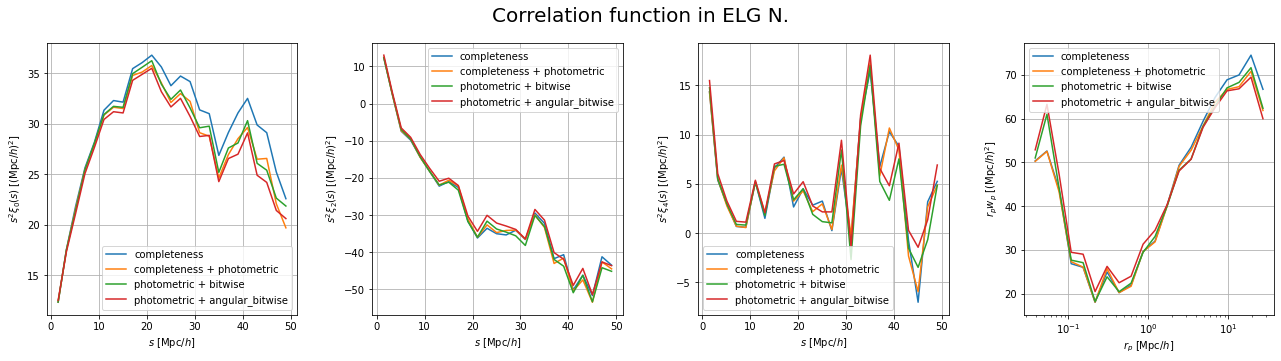

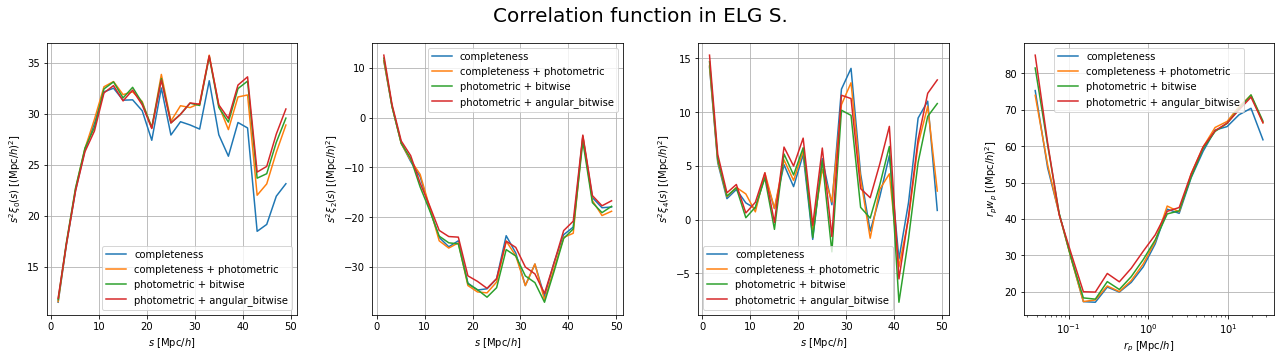

In [5]:
zlim = {'LRG':(0.4, 1.1), 'ELG': (0.8, 1.5), 'QSO': (0.8, 2.1)}
for tracer in ['LRG', 'ELG', 'QSO'][1:2]:
    for region in ['N', 'S']:
        ells = (0, 2, 4)
        fig, lax = plt.subplots(ncols=len(ells) + 1, nrows=1, sharex=False, sharey=False, figsize=(22, 5))
        fig.suptitle('Correlation function in {} {}.'.format(tracer, region), fontsize=20)
        fig.subplots_adjust(hspace=0.2, wspace=0.3)
        lax = lax.flatten()
        weight_types = ['completeness', 'completeness + photometric', 'photometric + bitwise', 'photometric + angular_bitwise']
        colors = ['C{:d}'.format(i) for i in range(len(weight_types))]
        for weight_type, color in zip(weight_types, colors):
            (sep, xiell), wang = compute_correlation_function(mode='multi', edges=np.linspace(1e-4, 50, 26), tracer=tracer, region=region, zlim=zlim[tracer], weight_type=weight_type)
            for ill, ax in enumerate(lax[:-1]):
                ax.plot(sep, sep**2*xiell[ill], label=weight_type, color=color)
                ax.grid(True)
                ax.legend()
                ax.set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
                ax.set_ylabel(r'$s^{{2}}\xi_{{{:d}}}(s)$ [$(\mathrm{{Mpc}}/h)^{{2}}$]'.format(ells[ill]));
            (sep, wp), wang = compute_correlation_function(mode='wp', edges=np.logspace(-1.5, 1.5, 21), tracer=tracer, region=region, zlim=zlim[tracer], weight_type=weight_type, wang=wang)
            ax = lax[-1]
            ax.plot(sep, sep*wp, label=weight_type, color=color)
            ax.grid(True)
            ax.legend()
            ax.set_xscale('log')
            ax.set_xlabel('$r_{p}$ [$\mathrm{Mpc}/h$]')
            ax.set_ylabel('$r_{p} w_{p}$ [$(\mathrm{{Mpc}}/h)^{{2}}$]')

[001045.89]  11-04 10:02  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001046.01]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001046.01]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.


[001046.25]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001047.87]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001052.47]  11-04 10:02  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001052.49]  11-04 10:02  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/LRG_imaging_weight_512.npy
[001052.65]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001052.65]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.


[001052.81]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001054.41]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001059.12]  11-04 10:02  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001059.24]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001059.24]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.


[001059.44]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001061.57]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001067.84]  11-04 10:02  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001067.86]  11-04 10:02  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/LRG_imaging_weight_512.npy


[001068.11]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001068.11]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[001068.32]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001070.52]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001077.14]  11-04 10:02  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001077.28]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001077.28]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.


[001077.74]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001080.03]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001083.58]  11-04 10:02  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001083.62]  11-04 10:02  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy


[001083.87]  11-04 10:02  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001083.87]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.
[001084.35]  11-04 10:02  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001086.58]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001089.95]  11-04 10:03  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001090.09]  11-04 10:03  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001090.09]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.


[001090.61]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001093.56]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.
[001097.14]  11-04 10:03  astropy                      WARNING  MergeConflictWarning: Cannot merge meta key 'DEPVER08' types <class 'astropy.io.fits.card.Undefined'> and <class 'astropy.io.fits.card.Undefined'>, choosing DEPVER08=<astropy.io.fits.card.Undefined object at 0x2aaad3c78670>
[001097.18]  11-04 10:03  root                         INFO     Read imaging weight: /global/cfs/cdirs/desi/users/edmondc/Imaging_weight/SV3/ELG_imaging_weight_512.npy
[001097.33]  11-04 10:03  TwoPointCorrelationFunction  INFO     Using estimator LandySzalayTwoPointEstimator.
[001097.33]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts D1D2.


[001097.88]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts D1R2.
[001100.67]  11-04 10:03  TwoPointCorrelationFunction  INFO     Computing pair counts R1R2.


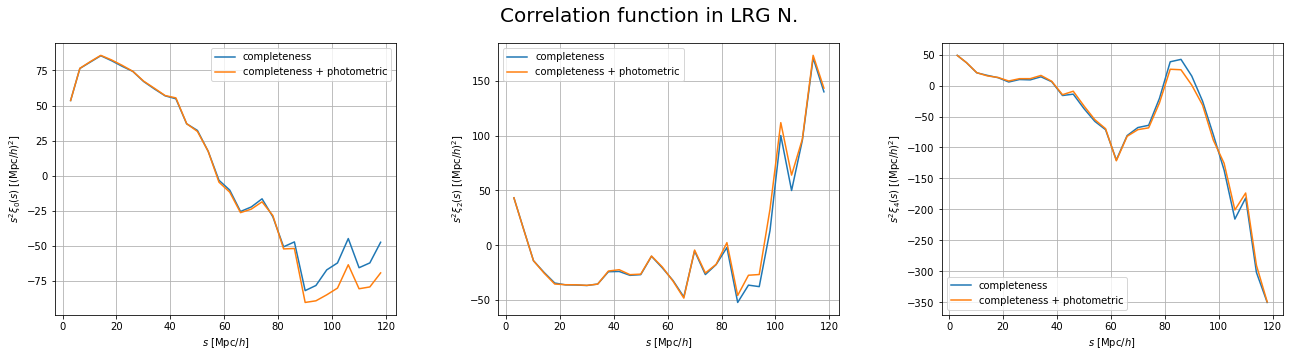

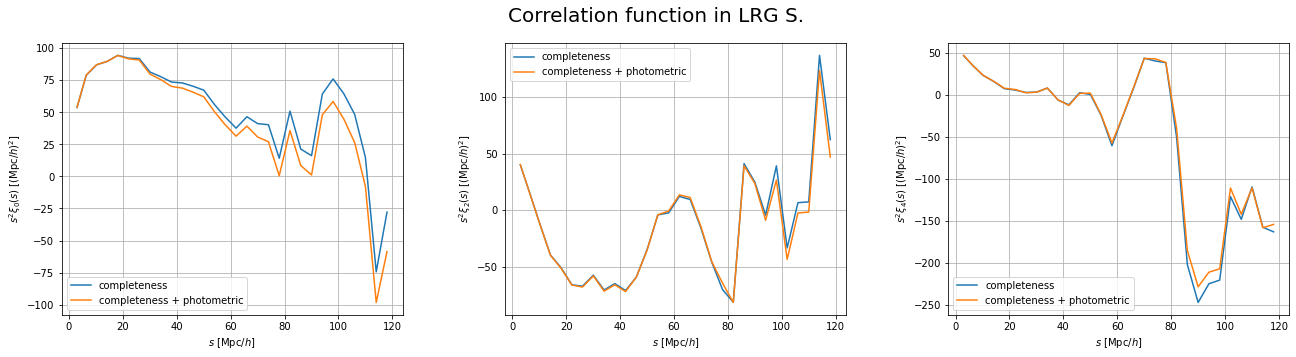

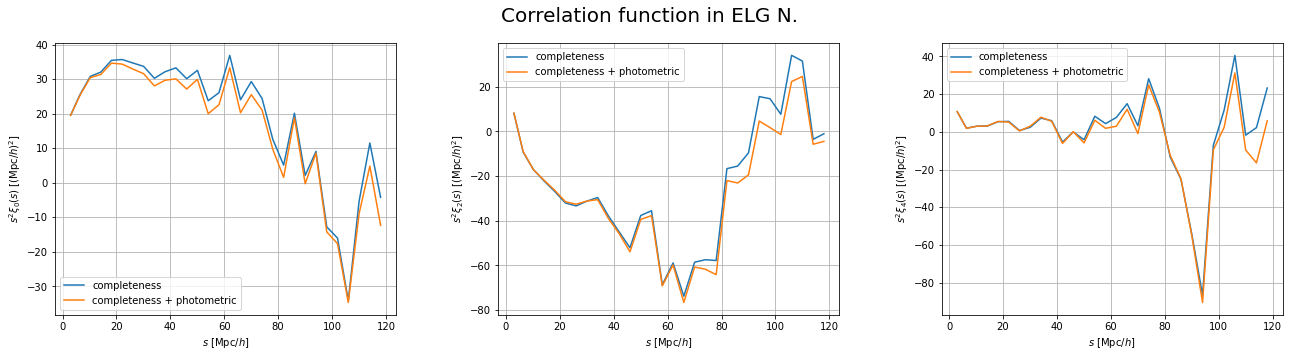

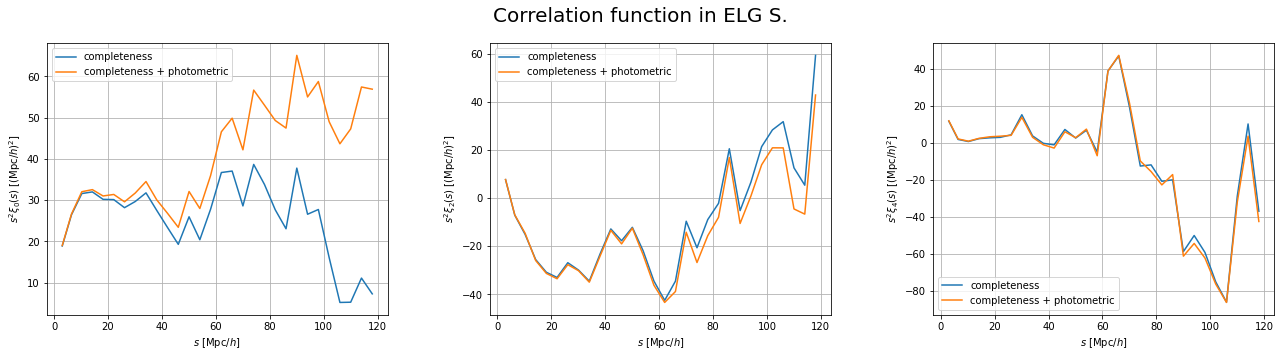

In [6]:
zlim = {'LRG':(0.4, 1.1), 'ELG': (0.8, 1.6), 'QSO': (0.8, 2.1)}
for tracer in ['LRG', 'ELG', 'QSO'][:2]:
    for region in ['N', 'S']:
        ells = (0, 2, 4)
        fig, lax = plt.subplots(ncols=len(ells), nrows=1, sharex=False, sharey=False, figsize=(22, 5))
        fig.suptitle('Correlation function in {} {}.'.format(tracer, region), fontsize=20)
        fig.subplots_adjust(hspace=0.2, wspace=0.3)
        lax = lax.flatten()
        weight_types = ['completeness', 'completeness + photometric']
        colors = ['C{:d}'.format(i) for i in range(len(weight_types))]
        for weight_type, color in zip(weight_types, colors):
            (sep, xiell), wang = compute_correlation_function(mode='multi', edges=np.linspace(1e-4, 120, 31), tracer=tracer, region=region, zlim=zlim[tracer], weight_type=weight_type,
                                                              nrandoms=2, nthreads=16)
            for ill, ax in enumerate(lax):
                ax.plot(sep, sep**2*xiell[ill], label=weight_type, color=color)
                ax.grid(True)
                ax.legend()
                ax.set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
                ax.set_ylabel(r'$s^{{2}}\xi_{{{:d}}}(s)$ [$(\mathrm{{Mpc}}/h)^{{2}}$]'.format(ells[ill]));